In [1]:
import sys
import os
import itertools

import numpy as np
import scipy.stats as stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


sys.path.append("../../ndsvae/")
import ndsvae as ndsv

sys.path.append("..")
import plot
import plotutils as pu
import util


%matplotlib inline
%load_ext autoreload
%autoreload 2

## Matplotlib config

In [2]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Load data

In [3]:
! ls ../run/hcp/hcp100_linw_dicer/

dataset.npz  img  modelAB  modelAN  surrogates.npz


In [4]:
conn = "linw"
preproc = "dicer"
modelname1 = "AN"
modelname2 = "AB"
config = "ns_3_mreg_3_msub_0_nf_32"
isub = 5

In [5]:
ds = ndsv.Dataset.from_file(f"../run/hcp/hcp100_{conn}_{preproc}/dataset.npz")

run1 = util.select_run_fc(f"hcp100_{conn}_{preproc}", modelname1, config, [0,1], "hcp")
run2 = util.select_run_fc(f"hcp100_{conn}_{preproc}", modelname2, config, [0,1], "hcp")

direc1 = f"../run/hcp/hcp100_{conn}_{preproc}/model{modelname1}/{config}/run{run1:02d}"
direc2 = f"../run/hcp/hcp100_{conn}_{preproc}/model{modelname2}/{config}/run{run2:02d}"

sims1 = ndsv.GeneratedData.from_file(os.path.join(direc1, f"simulations/simulations_{isub:03d}.npz"))    
sims2 = ndsv.GeneratedData.from_file(os.path.join(direc2, f"simulations/simulations_{isub:03d}.npz"))

params1 = util.load_params(os.path.join(direc1, "parameters"))
params2 = util.load_params(os.path.join(direc1, "parameters"))

model1 = util.get_model(modelname1, config, ds)
model1.load_weights(os.path.join(direc1, "fit/model"))

model2 = util.get_model(modelname2, config, ds)
model2.load_weights(os.path.join(direc2, "fit/model"))

nt = ds.y.shape[-1]

2022-08-01 17:54:23.927172: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-01 17:54:23.928611: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Separate panels

In [6]:
colors = ['tab:blue', 'tab:green']

def plot_obs_all(ax, t, y, iregs, title=None):
    plt.sca(ax)
    if title:
        plt.title(title)
    plt.imshow(y, aspect='auto', interpolation='none', vmin=-2.5, vmax=2.5, cmap='magma')
    plt.yticks([])
    plt.xticks([])
    plt.ylabel("Regions")
    
    for i, ireg in enumerate(iregs):
        plt.scatter(-1, ireg, color=colors[i], marker=5, clip_on=False, s=20, lw=0)
    plt.xlim(0, y.shape[1])
    
def plot_fc(ax, cax, y):
    plt.sca(ax)
    plt.title("Functional conn.")
    fc = np.corrcoef(y)
    im = plt.imshow(fc, vmin=-1, vmax=1, cmap='bwr', interpolation='none')
    plt.xticks([])
    plt.yticks([])    
    plt.xlabel("Regions")
    plt.ylabel("Regions")
    
    if cax is not None:
        plt.colorbar(im, cax=cax, orientation='vertical')
        cax.tick_params(axis=u'y', which=u'both',length=0)
        
        
def plot_obs_lines(ax, t, ys, labels, offset=4, us=None):
    n = len(ys)
    
    plt.sca(ax)
    for i, y in enumerate(ys):
        plt.plot(t, y - offset*i, color=colors[i], lw=0.5)
    
    if us is not None:
        plt.plot(t, us + 1.5*offset, color='k', lw=0.5)

    plt.xlim(t[0], t[-1])    
    plt.xlabel("Time")
    plt.xticks([])

    plt.ylim(-n*offset, 2.5*offset)
    if us is None:
        plt.yticks(-offset*np.r_[0:n], labels)
    else:
        plt.yticks(list(-offset*np.r_[0:n]) + [1.5*offset], list(labels) + ["Input"])
                
    for ytick, color in zip(ax.get_yticklabels()[:n], colors[:n]):
        ytick.set_color(color)
    pu.bottomleft_spines(ax)

        
def plot_observations(gs, t, y, examples, us=None):
    # left, right, bottom, top = pos
    
    # gs = fig.add_gridspec(nrows=2, ncols=2, height_ratios=[2,1], width_ratios=[2,1.4],
    #                       left=left, right=right, bottom=bottom, top=top, hspace=0.6, wspace=0.3)
    ax1 = plt.subplot(gs[0,0])
    plot_obs_all(ax1, t, y, examples, title="Timeseries")

    labels = "ABCDEFGHI"[:len(examples)]    
    ax2 = plt.subplot(gs[1,0])
    plot_obs_lines(ax2, t, y[examples], labels=labels, offset=4, us=us)
    # plt.xlim(0,150)
    
    vpos = 7 if us is None else 12
    plt.plot([60, 120], [vpos,vpos], lw=2, color='k', clip_on=False)
    plt.text(90, vpos+1, "60 s", ha='center', va='bottom', clip_on=False, fontsize=8)

    ax3 = plt.subplot(gs[0,1])
    box = ax3.get_position()
    fig = ax3.figure
    cax3 = fig.add_axes([box.x0+box.width+0.005,box.y0+0.2*box.height,0.01,0.6*box.height])
    plot_fc(ax3, cax3, y)        

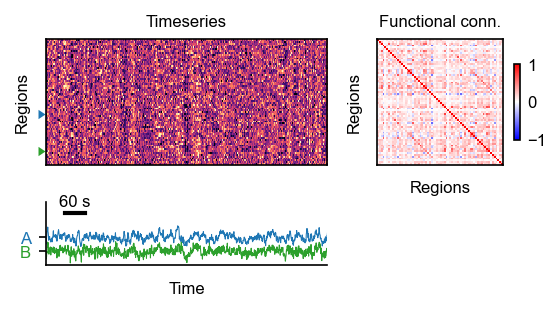

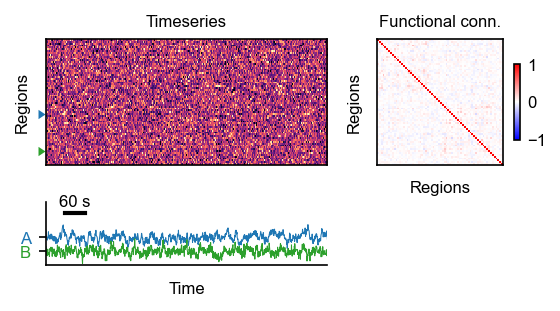

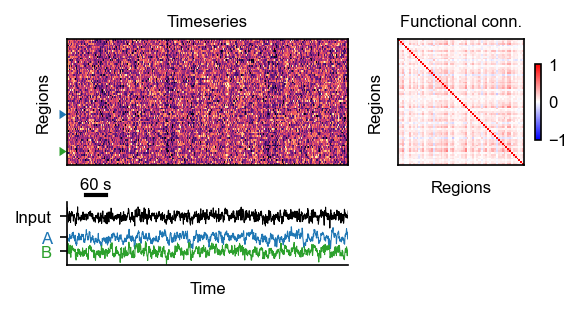

In [7]:
isample = 3
iregs = [40, 60]

plt.figure(figsize=(4,2), dpi=150)
gs = gridspec.GridSpec(2, 2, width_ratios=(2,1), height_ratios=(2,1), hspace=0.4)
plot_observations(gs, ds.t, ds.y[isub,:,0,:], iregs)

plt.figure(figsize=(4,2), dpi=150)
gs = gridspec.GridSpec(2, 2, width_ratios=(2,1), height_ratios=(2,1), hspace=0.4)
plot_observations(gs, ds.t, sims1.y[isample,0,:,0,-nt:], iregs)

plt.figure(figsize=(4,2), dpi=150)
gs = gridspec.GridSpec(2, 2, width_ratios=(2,1), height_ratios=(2,1), hspace=0.4)
plot_observations(gs, ds.t, sims2.y[isample,0,:,0,-nt:], iregs, us=sims2.us[isample,0,-nt:])



### State space

In [8]:
def phaseplot2d(ax, model, c1, c2, x, thetareg, thetasub, u=0., ushared=0., scale=6, color='k'):
    assert c1 != c2
    
    plt.sca(ax)
    fx = ndsv.models.evalf(model, x, thetareg=thetareg, thetasub=thetasub, u=u, ushared=ushared)
        
    if c1 < c2: u, v = fx[:,:,c1].T, fx[:,:,c2].T
    else:       u, v = fx[:,:,c1], fx[:,:,c2]
        
    # plt.quiver(x[c1], x[c2], u, v, scale=scale, color=color)
    plt.streamplot(x[c1], x[c2], u, v, density=0.5, linewidth=0.5, arrowsize=0.25, color=color)
    
    velocity = np.sqrt(u**2 + v**2)
    plt.imshow(velocity, cmap='plasma', extent=[x[c1][0], x[c1][-1], x[c2][0], x[c2][-1]], origin='lower',
               alpha=0.5, zorder=-1, vmin=0, vmax=3)


def plot_phaseplot(ax, model, x, treg, tsub, dims=(0,1), dimnames=(1,2), nquiver=10, color='k', label=None,
                   xlabels=True, ylabels=True):
    
    plt.sca(ax)
    rng = (-2., 2.)
    
    for i in range(x.shape[0]):
        plt.plot(x[i,dims[0]], x[i,dims[1]], color='yellow', alpha=1, lw=0.25, zorder=10)
    
    xq = [0. for _ in range(model.ns)]
    xq[dims[0]] = np.linspace(rng[0], rng[1], nquiver)
    xq[dims[1]] = np.linspace(rng[0], rng[1], nquiver)
    phaseplot2d(ax, model, dims[0], dims[1], x=xq, thetareg=treg, thetasub=tsub,
                u=0., ushared=0., scale=20, color='k')
    plt.xlim(rng); plt.ylim(rng)
    
    plt.xticks([-2,0,2], None if xlabels else ["","",""])
    if xlabels: plt.xlabel(f"$x_{dimnames[0]}$", labelpad=0)
        
    plt.yticks([-2,0,2], None if ylabels else ["","",""])
    if ylabels: plt.ylabel(f"$x_{dimnames[1]}$", labelpad=0)
    
    if label:
        plt.text(0.04, 0.96, label, ha='left', va='top', transform=ax.transAxes, color=color, fontsize=8, 
                 bbox=dict(boxstyle='square', facecolor='white', alpha=0.85))
        
    
    for pos in ['bottom', 'top', 'right', 'left']:
        ax.spines[pos].set_color(color)
        ax.spines[pos].set_linewidth(1.5)
    ax.tick_params(axis='both', colors=color)
    ax.xaxis.label.set_color(color)
    ax.yaxis.label.set_color(color)

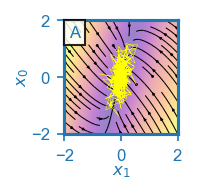

In [9]:
plt.figure(figsize=(1,1), dpi=150)
plot_phaseplot(plt.gca(), model1, sims1.x[isample:isample+1,0,iregs[0],:,-nt//2:-nt//4],
               treg=params1.thetareg[isub,iregs[0],:,0], tsub=params1.thetasub[isub,:,0],
               dims=(2,1), dimnames=(1,0), nquiver=50,
               color=colors[0],
               label="A", xlabels=True)

### FC similarity

In [10]:
def get_fc_similarity(preproc, config, models):
    nreg = 68
    nsub = 100
    nsamples = 50
    nmodels = len(models)
    
    runs = np.array([util.select_run_fc(f"hcp100_{conn}_{preproc}", modelname, config, [0,1], "hcp") 
                     for conn, modelname in models])
    
    pc = np.zeros((nmodels, nsub, nsamples))
    
    for i, (conn, model) in enumerate(models):
        fc = np.load(
            f"../run/hcp/hcp100_{conn}_{preproc}/model{model}/{config}/run{runs[i]:02d}/simulations/fc.npz")
        pc[i] = fc['similarity']
                
    return pc        
        
conns = ['linw', 'linwhom', 'logw', 'logwhom']
modelnames = ['AN', 'AB']
models = [(conn, model) for model in modelnames for conn in conns]

fc_pc = get_fc_similarity(preproc, config, models)

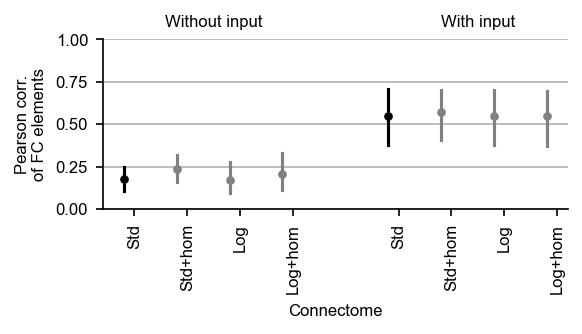

In [11]:
def plot_fc_similarity(ax, pc1, pc2, models, connlabels):
    nconns, nsub, nsamples = pc1.shape
    space = 1
    nsub_example = 20
    
    color1 = '0.0'
    color2 = '0.5'
    
    for k, pc in enumerate([pc1, pc2]):        
        for i in range(nconns):
            color = color1 if i == 0 else color2            
            cpos = (nconns+space)*k + i    
            plt.plot([cpos,cpos], np.percentile(pc[i,:,:], [5,95]), color=color, lw=1.5, zorder=10)
            plt.scatter(cpos, np.median(pc[i,:,:]), s=10, color=color, zorder=10)

#             for j in range(nsub_example):
#                 color = color2                
#                 spos = cpos + 0.1 + 0.05*j
#                 plt.plot([spos, spos], np.percentile(pc[i,j,:], [5,95]), color=color, lw=0.5, zorder=10)

    plt.ylabel('Pearson corr.\nof FC elements')
    plt.ylim(0, 1)
    plt.yticks([0, 0.25, 0.5, 0.75, 1])
    
    labelpos = np.concatenate([np.r_[:nconns], np.r_[:nconns] + nconns + space]) + 0.2
    labels = np.concatenate([connlabels, connlabels])
    
    plt.xticks(labelpos, labels, rotation='vertical')
    plt.xlabel("Connectome", labelpad=5)
    
    plt.grid(axis='y', zorder=-10)
    pu.bottomleft_spines(ax)
    
    plt.text(1.7, 1.1, "Without input", ha='center', va='center', fontsize=8)
    plt.text(nconns+space+1.7, 1.1, "With input", ha='center', va='center', fontsize=8)
    

connlabels = ["Std", "Std+hom", "Log", "Log+hom"]
    
plt.figure(figsize=(4,1.5), dpi=150)
plot_fc_similarity(plt.gca(), fc_pc[:4], fc_pc[4:], models, connlabels)

## Order of state dimensions

In [12]:
params1.x.shape

(100, 68, 3, 1200, 2)

In [13]:
def calc_kl_timeseries(x, nsamples=10):
    nsub, nreg, ns, nt, _ = x.shape
        
    kl = np.full((nsub, nreg, ns, nt-1), np.nan)

    for (isub, ireg) in itertools.product(range(nsub), range(nreg)):
        xr = x[isub,ireg,:,1:,:]  # Note: we are removing the initial conditions
        ntm = nt - 1
        
        x1mu, x1std  = xr[:,:,0], xr[:,:,1]        
        xsamples = np.random.normal(x1mu[:,:,None], x1std[:,:,None], size=(ns, ntm, nsamples))        
        x2mu  = np.mean(np.reshape(xsamples, (ns, ntm*nsamples)), axis=1)
        x2std = np.std(np.reshape(xsamples, (ns, ntm*nsamples)), axis=1)

        for i in range(ns):
            kl[isub,ireg,i,:] = (np.log(x2std[i]/x1std[i]) 
                                 + (x1std[i]**2 + (x1mu[i] - x2mu[i])**2)/(2*x2std[i]**2) - 0.5)
    return np.mean(kl, axis=(0,1,3))

In [14]:
order1 = np.argsort(-calc_kl_timeseries(params1.x))
order2 = np.argsort(-calc_kl_timeseries(params2.x))

In [15]:
order1

array([1, 2, 0])

In [16]:
np.argsort(params1.thetareg[5,:,0,0])

array([42,  8, 66, 18,  1, 34, 51, 62,  0, 46, 23, 58, 57, 54, 55, 19, 24,
       32, 53, 48, 20, 31,  3, 52, 44, 25, 30, 47, 28, 45, 65, 21, 12, 13,
       64,  9, 14,  4, 17, 59, 22, 38, 16, 56, 43, 63,  6, 67, 11, 29, 10,
       36, 26, 50,  2, 39, 37, 60, 49,  7, 15, 35,  5, 33, 41, 27, 40, 61])

## Figure

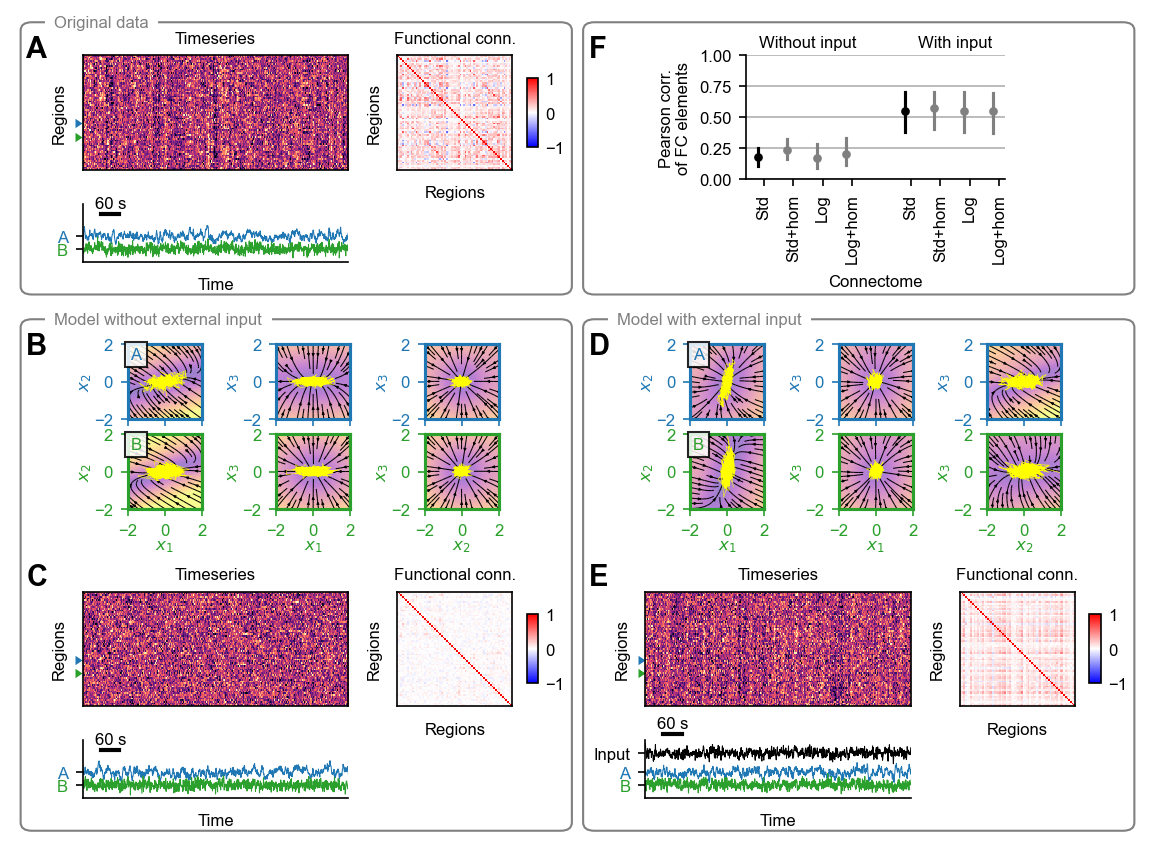

In [17]:
isub = 5
isample = 3
# iregs = [40, 60]
iregs = [40, 48]

fig = plt.figure(figsize=(7.5,5.5), dpi=150)


gs1 = fig.add_gridspec(nrows=2, ncols=2, left=0.06, right=0.45, bottom=0.7, top=0.95,
                       width_ratios=[2,1], height_ratios=[2,1], hspace=0.4)

gs3 = fig.add_gridspec(nrows=2, ncols=2, left=0.06, right=0.45, bottom=0.05, top=0.3,
                       width_ratios=[2,1], height_ratios=[2,1], hspace=0.4)

gs5 = fig.add_gridspec(nrows=2, ncols=2, left=0.56, right=0.95, bottom=0.05, top=0.3,
                       width_ratios=[2,1], height_ratios=[2,1], hspace=0.4)

gs2 = fig.add_gridspec(nrows=2, ncols=3, left=0.10, right=0.43, bottom=0.40, top=0.6, wspace=1.)
gs4 = fig.add_gridspec(nrows=2, ncols=3, left=0.60, right=0.93, bottom=0.40, top=0.6, wspace=1.)

gs6 = fig.add_gridspec(nrows=1, ncols=1, left=0.65, right=0.88, bottom=0.8, top=0.95)



# Panels A
plot_observations(gs1, ds.t, ds.y[isub,:,0,:], iregs)

# Panels B
for i, (ireg, label) in enumerate(zip(iregs, ['A', 'B'])):
    for j, dims in enumerate([(0,1), (0,2), (1,2)]):
        truedims = order1[list(dims)]        
        ax = plt.subplot(gs2[i,j])
        plot_phaseplot(ax, model1, sims1.x[isample:isample+1,0,iregs[i],:,-nt//2:-nt//4],
                       treg=params1.thetareg[isub,iregs[i],:,0], tsub=params1.thetasub[isub,:,0],
                       dims=truedims, dimnames=(dims[0]+1, dims[1]+1), nquiver=50,
                       color=colors[i],
                       label=(label if j == 0 else ""), xlabels=(i==1))


# Panels C
plot_observations(gs3, ds.t, sims1.y[isample,0,:,0,-nt:], iregs)

# Panels D
for i, (ireg, label) in enumerate(zip(iregs, ['A', 'B'])):
    for j, dims in enumerate([(0,1), (0,2), (1,2)]):
        truedims = order2[list(dims)]      
        ax = plt.subplot(gs4[i,j])
        plot_phaseplot(ax, model2, sims2.x[isample:isample+1,0,iregs[i],:,-nt//2:-nt//4],
                       treg=params2.thetareg[isub,iregs[i],:,0], tsub=params2.thetasub[isub,:,0],
                       dims=truedims, dimnames=(dims[0]+1, dims[1]+1), nquiver=50,
                       color=colors[i],
                       label=(label if j == 0 else ""), xlabels=(i==1))

# Panels E
plot_observations(gs5, ds.t, sims2.y[isample,0,:,0,-nt:], iregs, us=sims2.us[isample,0,-nt:])

# Panel F
plot_fc_similarity(plt.subplot(gs6[0]), fc_pc[:4], fc_pc[4:], models, connlabels)

bg = pu.Background(visible=False)
bg.add_labels([0.01, 0.01, 0.01, 0.51, 0.51, 0.51], [0.94, 0.58, 0.3, 0.58, 0.3, 0.94], fontsize=14)

bg.box((0.015, 0.485, 0.67, 0.98), pad=0.01, title="Original data", titlestyle={'fontsize':8})
bg.box((0.015, 0.485, 0.02, 0.62), pad=0.01, title="Model without external input", titlestyle={'fontsize':8})
bg.box((0.515, 0.985, 0.02, 0.62), pad=0.01, title="Model with external input", titlestyle={'fontsize':8})
bg.box((0.515, 0.985, 0.67, 0.98), pad=0.01)

plt.savefig(f"./img/Fig_HCP_ModelComparison.pdf")